## Customer segmentation for Ad

## Target Marketing Campaign

The dataset contains patient data to what type of campaign they responded to via a company's healthcare data app. They would send out reminders about their healthcare regulations and each patient has been **targeted** with these campaigns:

1. Emails
2. SMS
3. Whatapp
4. Pamphlets
5. Telephone
6. Long Letters


The target of the problem is to help us find the accurate way to **deploy Ad**


### 1. Inport Libraries

In [175]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

### 2. Load dataset

In [176]:
# the type of campaign --> 6 campaign type
campaign_type = pd.read_excel("campaign_response.xlsx", sheetname=0)
# 
print("There has {} types of campaigns".format(len(campaign_type["Type"].value_counts())))
campaign_type.head()

There has 6 types of campaigns


,CampaignID,Type,Month
0,1,email,January
1,2,email,January
2,3,SMS,February
3,4,WhatsApp,February
4,5,Long letter,February


In [177]:
# The patient who response to the Ad campaign
campaign_response = pd.read_excel("campaign_response.xlsx", sheetname=1)
# Ad one response feature
campaign_response["response"] = 1
print("There has {} number of patients who responded".format(len(campaign_response["Patient"].value_counts())))
campaign_response.head()

There has 96 number of patients who responded


,Patient,CampaignID,response
0,10,1,1
1,23,1,1
2,24,1,1
3,40,1,1
4,55,1,1


### 3. Merge dataset

In [178]:
# Merge on the CampaignID columns
merge_campaign = pd.merge(campaign_type, campaign_response, on="CampaignID")

In [179]:
# merge_campaign = merge_campaign[["Patient", "response", "Month", "Type", "CampaignID"]]

In [180]:
print("\n The shape of the merged campaign dataset is: " + str(merge_campaign.shape))
merge_campaign.head()


 The shape of the merged campaign dataset is: (324, 5)


,CampaignID,Type,Month,Patient,response
0,1,email,January,10,1
1,1,email,January,23,1
2,1,email,January,24,1
3,1,email,January,40,1
4,1,email,January,55,1


### 4. Creat Pivot Table of Patients & Campaign Responses

In [181]:
pivot_campaign = merge_campaign.pivot_table(index=["Patient"],
                                            columns = ["CampaignID"],
                                            values="response"
                                           )

In [182]:
pivot_campaign = pivot_campaign.fillna(0).reset_index()

### 5. KMeans Clustering

In [183]:
import pylab as pl
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

### 6. Plot Elbow Curve

In [184]:
# KMeans algorithm only have 1 input
k = range(1, 15)
kmeans = [KMeans(n_clusters=i) for i in k]
score = [kmeans[i].fit(pivot_campaign[pivot_campaign.columns[2:]]).score(pivot_campaign[pivot_campaign.columns[2:]]) for i in range(len(kmeans))]

In [185]:
scores = []
for i in range(len(kmeans)):
    score = kmeans[i].fit(pivot_campaign[pivot_campaign.columns[2:]]).score(pivot_campaign[pivot_campaign.columns[2:]])
    scores.append(score)

Text(0.5, 1.0, 'Elbow Curve')

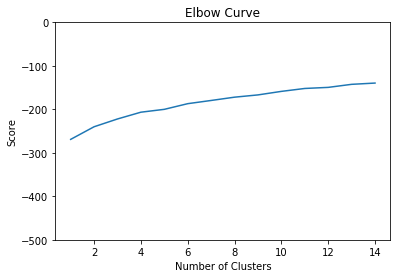

In [186]:
pl.plot(k, np.array(scores))
pl.xlabel("Number of Clusters")
pl.ylabel("Score")
pl.ylim(-500, 0)
pl.title("Elbow Curve")

### 7. Create Clusters

In [187]:
cluster = KMeans(n_clusters = 3)
pivot_campaign["cluster"] = cluster.fit_predict(pivot_campaign[pivot_campaign.columns[2:]])

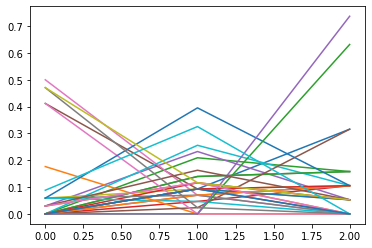

In [192]:
plt.plot(cluster.cluster_centers_)

### 8. Visualization  --> using PCA

In [189]:
# The input for PCA is only the number of components
pca = PCA(n_components = 2)
pivot_campaign['x'] = pca.fit_transform(pivot_campaign.iloc[:, 1:33])[:,0]
pivot_campaign['y'] = pca.fit_transform(pivot_campaign.iloc[:, 1:33])[:,1]
pivot_campaign = pivot_campaign.reset_index()

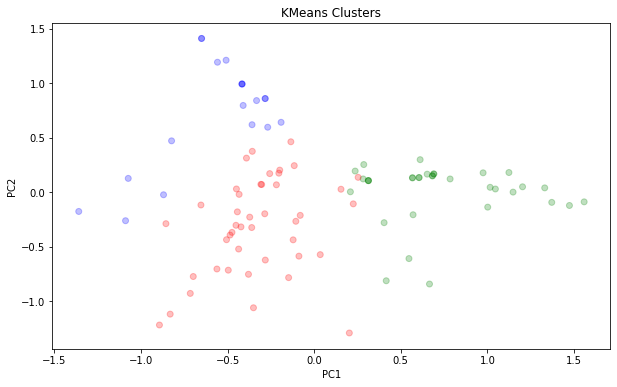

In [190]:
# generate the colormap for this 
import matplotlib.pyplot as plt


kmeans_colors = ['green' if c == 0 else 'blue' if c == 2 else 'red' for c in cluster.labels_]
fig = pl.figure(figsize=(10,6))
plt.scatter(x='x', y='y', data=pivot_campaign,
            alpha=0.25, color=kmeans_colors)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("KMeans Clusters")
plt.show()

In [104]:
campaign_cluster = pivot_campaign[["Patient", "cluster", "x", "y"]]
campaign_cluster.head()

CampaignID,Patient,cluster,x,y
0,1,2,0.975682,0.177733
1,2,0,-0.307802,0.071641
2,3,1,-0.416673,0.992914
3,4,2,0.547440,-0.609382
4,5,0,-0.379452,-0.753825


In [41]:
final_campaign = pd.merge(campaign_response, campaign_cluster)
final_campaign = pd.merge(campaign_type, final_campaign)
final_campaign.head()

,CampaignID,Type,Month,Patient,response,cluster,x,y
0,1,email,January,10,1,0,-0.282221,-0.622973
1,1,email,January,23,1,0,-0.496037,-0.715865
2,1,email,January,24,1,2,-1.073771,0.126451
3,1,email,January,40,1,0,-0.856150,-0.289071
4,1,email,January,55,1,2,-0.357379,0.375035


In [43]:
final_campaign["cluster_1"] = final_campaign.cluster == 0

In [44]:
final_campaign.groupby("cluster_1").Type.value_counts()

cluster_1  Type       
False      email          56
           SMS            50
           Telephone      26
           WhatsApp       23
           Pamphlet        3
           Long letter     1
True       WhatsApp       78
           Long letter    31
           email          20
           Telephone      17
           Pamphlet       12
           SMS             7
Name: Type, dtype: int64

In [45]:
final_campaign["cluster_2"] = final_campaign.cluster == 1
final_campaign.groupby("cluster_2").Type.value_counts()

cluster_2  Type       
False      WhatsApp       82
           email          60
           Long letter    31
           Telephone      19
           Pamphlet       15
           SMS             7
True       SMS            50
           Telephone      24
           WhatsApp       19
           email          16
           Long letter     1
Name: Type, dtype: int64